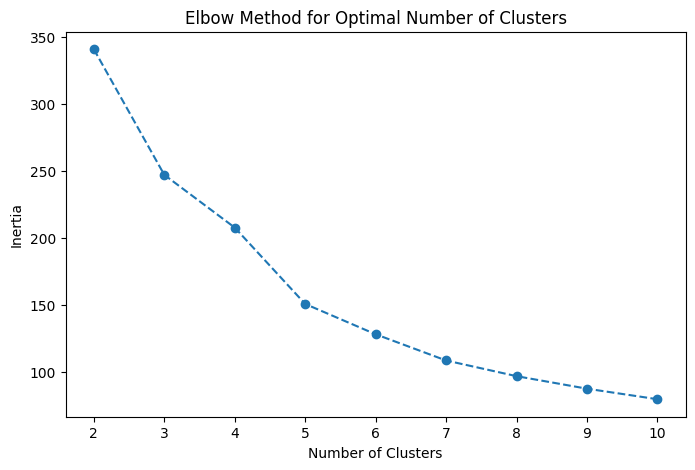

Davies-Bouldin Index: 1.060424039992303
Silhouette Score: 0.3135106549790538


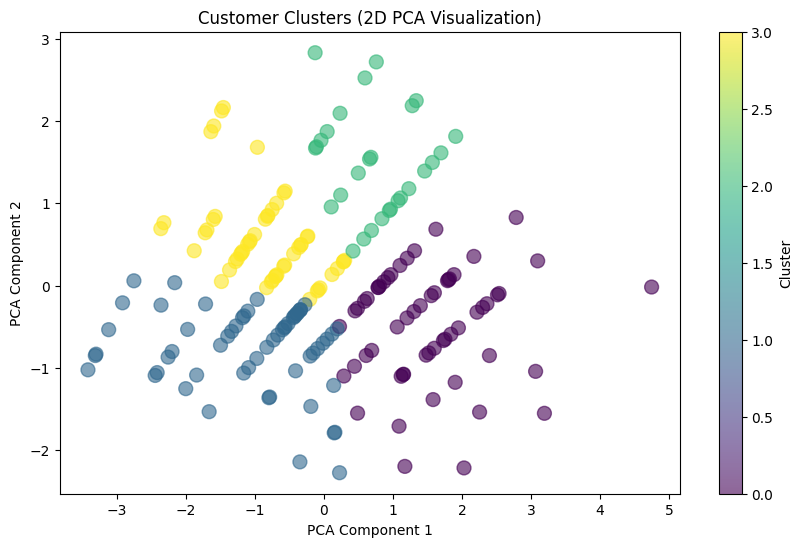


Cluster Summary:
   Cluster  TotalSpending  AvgTransactionValue  NumTransactions
0        0    5521.543966           741.147332         7.517241
1        1    2103.758333           435.310875         4.583333
2        2    4317.132143          1056.828643         4.142857
3        3    2313.977547           719.472764         3.264151


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge datasets on CustomerID
data = pd.merge(transactions, customers, on='CustomerID')

# Feature engineering: Aggregate customer-level features
customer_features = data.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'mean'],  # Total spending and average transaction value
    'Quantity': 'sum',              # Total quantity purchased
    'TransactionDate': 'nunique'    # Number of unique transaction dates
}).reset_index()

# Flatten MultiIndex columns
customer_features.columns = ['_'.join(col).strip() for col in customer_features.columns.values]

# Rename columns for clarity
customer_features.rename(columns={
    'CustomerID_': 'CustomerID',
    'TotalValue_sum': 'TotalSpending',
    'TotalValue_mean': 'AvgTransactionValue',
    'Quantity_sum': 'TotalQuantity',
    'TransactionDate_nunique': 'NumTransactions'
}, inplace=True)

# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features[['TotalSpending', 'AvgTransactionValue', 'NumTransactions']])

# Determine optimal number of clusters using the Elbow Method
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

# Perform clustering (e.g., K-Means with 4 clusters)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_features)
customer_features['Cluster'] = clusters

# Calculate clustering metrics
db_index = davies_bouldin_score(scaled_features, clusters)
silhouette = silhouette_score(scaled_features, clusters)
print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette}")

# Visualize clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
customer_features['PCA1'] = pca_features[:, 0]
customer_features['PCA2'] = pca_features[:, 1]

# Plot clusters
plt.figure(figsize=(10, 6))
plt.scatter(customer_features['PCA1'], customer_features['PCA2'], c=customer_features['Cluster'], cmap='viridis', s=100, alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Customer Clusters (2D PCA Visualization)')
plt.colorbar(label='Cluster')
plt.show()

# Analyze cluster characteristics
cluster_summary = customer_features.groupby('Cluster').agg({
    'TotalSpending': 'mean',
    'AvgTransactionValue': 'mean',
    'NumTransactions': 'mean'
}).reset_index()

print("\nCluster Summary:")
print(cluster_summary)